# Benchmarking & Evaluation Handbook (TensorFlow-centered)

_A practical notebook covering universal ML metrics, neural-network-specific diagnostics, transformer/NLP metrics, and small LM (perplexity) evaluation. Each major section contains a tiny runnable example, formulas, interpretation guidance, and notes on when to use the metric._

**Usage**: run cells sequentially in a Jupyter environment. The notebook uses TensorFlow and scikit-learn. Some cells call `pip` to install optional packages; run those if missing.

---


In [1]:
%pip install numpy pandas matplotlib scikit-learn tensorflow keras nltk sacrebleu

  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nltk]6/7 [nltk]ama]
Note: you may need to restart the kernel to use updated packages.


## Section 1 — Universal Benchmarks (accuracy, precision, recall, F1, ROC-AUC, log-loss, confusion matrix)

This section explains each metric with formulas, interpretation (high/low means), and a tiny runnable example using a small neural model on a binary task derived from MNIST.

**Metrics covered (formulas & meaning):**

- **Accuracy**: $\text{Accuracy} = \frac{TP + TN}{TP+TN+FP+FN}$. High is better; good baseline for balanced classes.
- **Precision**: $\text{Precision} = \frac{TP}{TP+FP}$. High precision = few false positives.
- **Recall (Sensitivity)**: $\text{Recall} = \frac{TP}{TP+FN}$. High recall = few false negatives.
- **F1 score**: $\text{F1} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$. Harmonic mean; good for imbalanced classes.
- **ROC-AUC**: Area under ROC curve; probability a random positive ranks above a random negative. 0.5 = random, 1.0 = perfect.
- **Log-loss (cross-entropy)**: $-\frac{1}{N} \sum_i [y_i \log \hat p_i + (1-y_i) \log (1-\hat p_i)]$. Lower is better; penalizes confident mistakes more.
- **Confusion matrix**: 2x2 table [[TN, FP],[FN, TP]] gives raw counts.

Each metric below prints value and short interpretation.


In [2]:
# Section 1 runnable example: binary MNIST (0 vs not-0) with a tiny MLP
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
import numpy as np

# Load MNIST and create binary task: digit 0 vs not-0
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

# Binary labels: 1 if digit==0 else 0
y_train_bin = (y_train.flatten() == 0).astype(int)
y_test_bin = (y_test.flatten() == 0).astype(int)

# Small subset for speed (adjust as needed)
x_train_s, y_train_s = x_train[:5000], y_train_bin[:5000]
x_test_s, y_test_s = x_test[:1000], y_test_bin[:1000]

# Tiny model
model = keras.Sequential([keras.layers.Dense(64, activation='relu', input_shape=(28*28,)),
                          keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train_s, y_train_s, epochs=5, batch_size=128, verbose=0)

# Predictions & metrics
probs = model.predict(x_test_s, verbose=0).flatten()
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test_s, preds)
prec = precision_score(y_test_s, preds, zero_division=0)
rec = recall_score(y_test_s, preds, zero_division=0)
f1 = f1_score(y_test_s, preds, zero_division=0)
auc = roc_auc_score(y_test_s, probs)
ll = log_loss(y_test_s, probs)
cm = confusion_matrix(y_test_s, preds)

print(f"Accuracy: {acc:.4f}   (higher is better; close to 1 is ideal)")
print(f"Precision: {prec:.4f}  (high -> few false positives)")
print(f"Recall: {rec:.4f}     (high -> few false negatives)")
print(f"F1 score: {f1:.4f}     (balanced precision & recall)")
print(f"ROC-AUC: {auc:.4f}     (0.5=random, 1.0=perfect)")
print(f"Log-loss: {ll:.4f}    (lower is better)")
print('\\nConfusion matrix (rows=actual 0/1, cols=pred 0/1):\\n', cm)


/Users/haidermalik/Documents/Code/CS_NOTES/Machine_Learning/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 0.9890   (higher is better; close to 1 is ideal)
Precision: 0.9302  (high -> few false positives)
Recall: 0.9412     (high -> few false negatives)
F1 score: 0.9357     (balanced precision & recall)
ROC-AUC: 0.9978     (0.5=random, 1.0=perfect)
Log-loss: 0.0336    (lower is better)
\nConfusion matrix (rows=actual 0/1, cols=pred 0/1):\n [[909   6]
 [  5  80]]


## Section 2 — Neural Network Specific Diagnostics

This section covers metrics and diagnostics specific to neural nets and training: training/validation curves, gradient norms, weight distributions, parameter count, FLOPs estimate, throughput (samples/sec), memory footprint, inference latency. For each, we provide a formula or method, interpretation, and a tiny example measuring gradient norms and training curves on Fashion-MNIST.

**Key diagnostics**:
- **Gradient norms**: During backpropagation, the model computes gradients (partial derivatives of the loss with respect to each parameter). The **gradient norm** is a single scalar that summarizes the magnitude of all gradients across the entire model, typically computed as the L2 (Euclidean) norm: $\|g\|_2 = \sqrt{\sum_i g_i^2}$, where $g_i$ are individual gradient components. **Interpretation**: Healthy gradient norms are typically neither too close to zero nor excessively large. Very small norms (e.g., <1e-5) indicate **vanishing gradients**, which slow or halt learning, especially in deep networks. Very large norms (e.g., >100 or exploding to NaN) indicate **exploding gradients**, often requiring gradient clipping. **Gradient clipping** is a technique that caps gradients at a threshold (e.g., clip norm to max value of 1.0 or 5.0) to prevent exploding gradients; it is commonly used in RNNs and transformers. Monitoring gradient norms during training helps diagnose optimization issues early.
- **Parameter count**: Higher parameter counts indicate more model capacity, but excessively large models may overfit or be inefficient. Balance parameter count with dataset size and task complexity.


- **Throughput**: Higher throughput (samples processed per second) is better, as it indicates faster training or inference. Watch for bottlenecks in hardware or data pipelines if throughput is low.
- **Inference latency**: Lower latency (time per sample) is better, especially for real-time applications. High latency may indicate inefficiencies in the model or hardware.
- **Weight distributions**: Healthy weight distributions should not be overly concentrated (e.g., all weights near zero) or excessively spread out. Saturated weights may indicate dead neurons or poor initialization. Should follow a bell curve (norm dist)
- **Training/validation curves**: Training loss should decrease steadily, and validation loss should follow a similar trend. Diverging curves may indicate overfitting or poor generalization.


Epoch 1 train_loss=0.9777 val_loss=0.6586 time=0.70s
Epoch 2 train_loss=0.5697 val_loss=0.5678 time=0.15s
Epoch 3 train_loss=0.4805 val_loss=0.5178 time=0.17s
Epoch 4 train_loss=0.4476 val_loss=0.4907 time=0.17s
Epoch 3 train_loss=0.4805 val_loss=0.5178 time=0.17s
Epoch 4 train_loss=0.4476 val_loss=0.4907 time=0.17s


2025-11-25 18:02:31.097895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 train_loss=0.4130 val_loss=0.4658 time=0.16s




Parameter count: 109386
Throughput (inference) ~ 62171.7 samples/sec over 0.13s


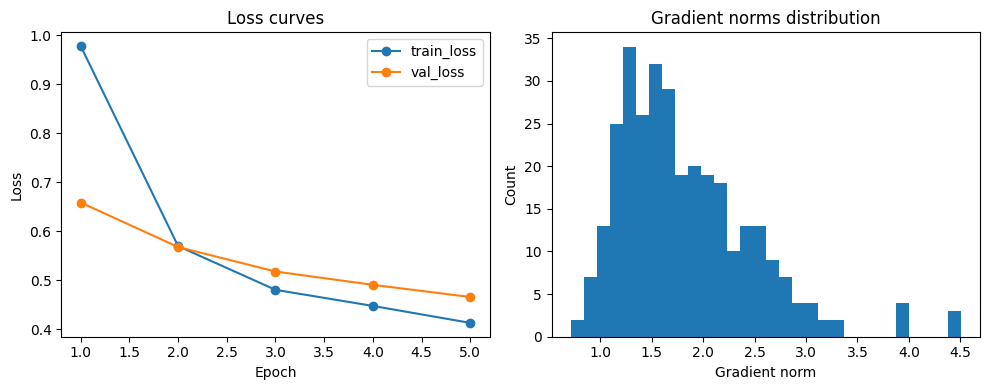

Avg inference latency per sample: 0.018 ms (over 2000 samples)
Weights: count=109386, mean=0.000980, std=0.060728


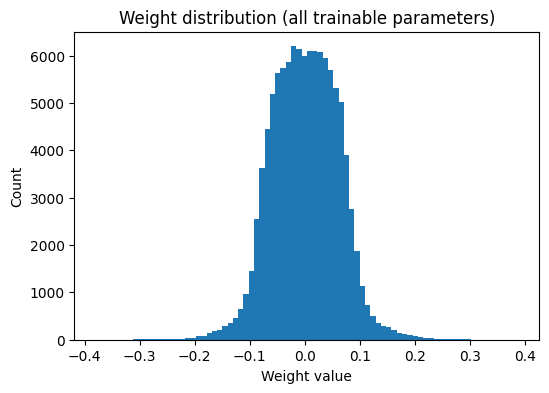

In [ ]:
# Section 2 runnable example: small MLP on Fashion-MNIST with gradient norms & training curve
import tensorflow as tf, time, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Load data (small subset)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28*28)/255.0
x_test = x_test.reshape(-1, 28*28)/255.0
x_train_s, y_train_s = x_train[:8000], y_train[:8000]
x_val_s, y_val_s = x_train[8000:10000], y_train[8000:10000]

batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model
model = keras.Sequential([layers.Dense(128, activation='relu'), layers.Dense(64, activation='relu'), layers.Dense(10)])
optimizer = keras.optimizers.Adam(1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# training loop capturing gradient norms and losses
grad_norms = []
train_losses = []
val_losses = []

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss = loss_fn(y, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    # compute global norm
    sq = tf.add_n([tf.reduce_sum(tf.square(g)) for g in grads if g is not None])
    gnorm = tf.sqrt(sq)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, gnorm

for epoch in range(5):
    t0 = time.time()
    epoch_loss = 0.0; steps=0
    for x_batch, y_batch in train_ds:
        loss, gnorm = train_step(x_batch, y_batch)
        epoch_loss += float(loss)
        grad_norms.append(float(gnorm))
        steps += 1
    train_losses.append(epoch_loss/steps)
    # val loss
    vl = np.mean([float(loss_fn(y, model(x, training=False))) for x,y in val_ds])
    val_losses.append(vl)
    print(f"Epoch {epoch+1} train_loss={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f} time={time.time()-t0:.2f}s")

# Parameter count and throughput (samples/sec)
param_count = np.sum([np.prod(v.shape) for v in model.trainable_variables])
print('\n\nParameter count:', param_count)

# Throughput simple measure on one epoch
t0 = time.time()
cnt = 0
for x_batch, y_batch in train_ds:
    _ = model(x_batch, training=False)
    cnt += x_batch.shape[0]
elapsed = time.time()-t0
print(f"Throughput (inference) ~ {cnt/elapsed:.1f} samples/sec over {elapsed:.2f}s")

# Plots
import matplotlib.pyplot as plt
# Loss curves (per epoch) -- add axis labels
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
epochs = list(range(1, len(train_losses) + 1))
plt.plot(epochs, train_losses, marker='o', label='train_loss')
plt.plot(epochs, val_losses, marker='o', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.legend()
# Gradient norms distribution (add axis labels)
plt.subplot(1,2,2)
plt.hist(grad_norms, bins=30); plt.xlabel('Gradient norm'); plt.ylabel('Count'); plt.title('Gradient norms distribution')
plt.tight_layout()
plt.show()
# Inference latency measurement (average time per sample in milliseconds)
# Warm-up a couple of batches to avoid first-call overhead
warmups = 3
cnt = 0
for i, (x_batch, y_batch) in enumerate(train_ds):
    if i >= warmups:
        break
    _ = model(x_batch, training=False)
# Now time one full pass (or a subset if dataset is large)
t0 = time.time()
cnt = 0
for x_batch, y_batch in val_ds:
    _ = model(x_batch, training=False)
    cnt += x_batch.shape[0]
elapsed = time.time() - t0
if cnt > 0:
    latency_ms = (elapsed / cnt) * 1000.0
    print(f"Avg inference latency per sample: {latency_ms:.3f} ms (over {cnt} samples)")
else:
    print("Could not measure inference latency: no samples counted.")
# Weight distribution: flatten all trainable variables and show histogram + stats
all_weights = np.concatenate([v.numpy().ravel() for v in model.trainable_variables]) if len(model.trainable_variables) > 0 else np.array([])
if all_weights.size > 0:
    print(f"Weights: count={all_weights.size}, mean={all_weights.mean():.6f}, std={all_weights.std():.6f}")
    plt.figure(figsize=(6,4))
    plt.hist(all_weights, bins=80)
    plt.title('Weight distribution (all trainable parameters)')
    plt.xlabel('Weight value')
    plt.ylabel('Count')
    plt.show()
else:
    print('No trainable weights found to plot weight distribution')


## Section 3 — Transformer / NLP-specific metrics (perplexity, BLEU, ROUGE, WER, embedding eval)

This section explains **Perplexity** in detail (formula, interpretation), and demonstrates a tiny language model trained as a next-word predictor to compute perplexity. We also explain BLEU/ROUGE conceptually and show a simple BLEU code snippet (nltk) for reference.

**Perplexity formula** (for token-level LM):
$$\text{Perplexity} = \exp\left( -\frac{1}{N} \sum_{i=1}^N \log p(w_i | w_{<i}) \right)$$
Lower perplexity = model assigns higher probability to true tokens. Per-token cross-entropy = negative log-probability; perplexity is exp of average cross-entropy.


In [4]:
# Section 3 runnable example: tiny word-level LM (keras) to compute perplexity
import tensorflow as tf, numpy as np, math
from tensorflow import keras
from tensorflow.keras import layers

# tiny corpus
corpus = "this is a tiny corpus for demonstration purpose it has a few sentences we will train a very small model to show how to compute perplexity on held-out text".lower().split()

# build vocab
vocab = sorted(set(corpus))
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

# create sequences (window size 3 -> predict next)
seq_len = 3
xs = []
ys = []
for i in range(len(corpus)-seq_len):
    xs.append([stoi[w] for w in corpus[i:i+seq_len]])
    ys.append(stoi[corpus[i+seq_len]])
xs = np.array(xs); ys = np.array(ys)

# train-test small split
split = int(0.8*len(xs))
x_train, y_train = xs[:split], ys[:split]
x_val, y_val = xs[split:], ys[split:]

# model: embed -> simple RNN -> softmax
vocab_size = len(vocab)
model = keras.Sequential([layers.Embedding(vocab_size, 16, input_length=seq_len),
                          layers.SimpleRNN(32),
                          layers.Dense(vocab_size, activation='softmax')])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train, epochs=60, verbose=0)

# compute average negative log likelihood on val set -> perplexity
probs = model.predict(x_val, verbose=0)  # shape (N, V)
true_probs = probs[np.arange(len(y_val)), y_val]
avg_nll = -np.mean(np.log(true_probs + 1e-12))
perplexity = math.exp(avg_nll)
print(f"Perplexity on tiny val set: {perplexity:.4f}")

# BLEU example (requires nltk): show how to call if you install nltk
print('\\nBLEU/ROUGE: For generation tasks you can use nltk or sacrebleu. Example usage (if nltk installed):')
print('from nltk.translate.bleu_score import sentence_bleu; sentence_bleu([reference_tokens], candidate_tokens)')

/Users/haidermalik/Documents/Code/CS_NOTES/Machine_Learning/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Perplexity on tiny val set: 35.8858
\nBLEU/ROUGE: For generation tasks you can use nltk or sacrebleu. Example usage (if nltk installed):
from nltk.translate.bleu_score import sentence_bleu; sentence_bleu([reference_tokens], candidate_tokens)


## Section 4 — LLM-specific metrics (overview) and relation to our tiny LM

This section summarizes LLM-level metrics: MMLU, BigBench, HELM, HumanEval, TruthfulQA, and explains when to use them and what they mean. Running full MMLU/HELM requires large models and evaluation harnesses; here we describe them and link to how they are computed and interpreted.

- **Perplexity**: core pretraining metric (lower better). Good for comparing LM perplexity curves during pretraining.
- **MMLU / BigBench / HELM**: task suites measuring knowledge, reasoning, robustness, bias/toxicity. Scores reported as accuracy or aggregated metrics; must be interpreted with human-in-the-loop.
- **HumanEval / CodeEval**: measure code generation correctness. Requires execution-based evaluation.
- **BLEU (Bilingual Evaluation Understudy)**: measures n-gram overlap between generated text and reference translations. Score 0-1 (or 0-100); higher is better. Widely used for machine translation but has limitations (doesn't capture semantic meaning, rewards exact matches). Example below shows basic usage.


In [8]:
# BLEU score example: comparing generated text to reference
# Install: pip install nltk sacrebleu (already in requirements above)
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Example 1: Single sentence BLEU
reference = [['the', 'cat', 'sat', 'on', 'the', 'mat']]  # list of reference token lists
candidate = ['the', 'cat', 'is', 'on', 'the', 'mat']     # candidate tokens

score = sentence_bleu(reference, candidate)
print(f"Sentence BLEU score: {score:.4f}")
print("Interpretation: 1.0 = perfect match, 0.0 = no overlap")

# Example 2: Corpus BLEU (multiple sentences)
references = [
    [['the', 'cat', 'sat', 'on', 'the', 'mat']],
    [['i', 'love', 'machine', 'learning']]
]
candidates = [
    ['the', 'cat', 'is', 'on', 'the', 'mat'],
    ['i', 'like', 'machine', 'learning']
]

corpus_score = corpus_bleu(references, candidates)
print(f"\nCorpus BLEU score: {corpus_score:.4f}")

# Example 3: Using sacrebleu (more standard implementation)
try:
    from sacrebleu import corpus_bleu as sb_corpus_bleu
    refs = [['the cat sat on the mat', 'i love machine learning']]  # list of lists of reference strings
    hyps = ['the cat is on the mat', 'i like machine learning']     # list of hypothesis strings
    bleu = sb_corpus_bleu(hyps, refs)
    print(f"\nSacreBLEU score: {bleu.score:.2f}")
    print(f"(SacreBLEU reports 0-100 scale)")
except ImportError:
    print("\nSacreBLEU not installed. Run: pip install sacrebleu")

print("\n⚠️ BLEU limitations:")
print("- Only measures surface n-gram overlap, not semantic similarity")
print("- Biased toward shorter outputs (brevity penalty helps but doesn't solve it)")
print("- For modern LLMs, combine BLEU with human eval and semantic metrics (BERTScore, etc.)")

/Users/haidermalik/Documents/Code/CS_NOTES/Machine_Learning/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Sentence BLEU score: 0.0000
Interpretation: 1.0 = perfect match, 0.0 = no overlap

Corpus BLEU score: 0.0000

SacreBLEU score: 30.21
(SacreBLEU reports 0-100 scale)

⚠️ BLEU limitations:
- Only measures surface n-gram overlap, not semantic similarity
- Biased toward shorter outputs (brevity penalty helps but doesn't solve it)
- For modern LLMs, combine BLEU with human eval and semantic metrics (BERTScore, etc.)

SacreBLEU score: 30.21
(SacreBLEU reports 0-100 scale)

⚠️ BLEU limitations:
- Only measures surface n-gram overlap, not semantic similarity
- Biased toward shorter outputs (brevity penalty helps but doesn't solve it)
- For modern LLMs, combine BLEU with human eval and semantic metrics (BERTScore, etc.)


## Section 5 — Choosing metrics & when to use them (expanded)

This is the practical quick-reference you should memorize:

- If your downstream cost is symmetric classification -> **accuracy**, but also check confusion matrix.
- If false positives are expensive -> **precision**. If false negatives are expensive -> **recall**.
- If dataset is imbalanced -> **PR-AUC** and **F1** (report both precision and recall separately as well).
- If model outputs probabilities used for decisions (risk, medical) -> **Calibration** (Brier score, reliability diagrams), **log-loss**.
- For ranking tasks -> **ROC-AUC** or average precision.
- For language models during pretraining -> **perplexity**; during evaluation -> **task accuracy / BLEU / human eval**.
- For generative models -> always combine automatic metrics (BLEU/ROUGE/BERTScore/Fréchet Inception Distance) with **human evaluation**.

_Practical sanity checklist to run after any experiment:_
1. Print confusion matrix. 2. Print accuracy + precision + recall + F1. 3. Plot training vs validation loss. 4. Measure inference latency & throughput. 5. If probabilities matter, run calibration test.


/Users/haidermalik/Documents/Code/CS_NOTES/Machine_Learning/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Brier score (lower better, perfect=0): 0.0108
PR-AUC (area under PR curve): 0.9725, Average precision: 0.9727


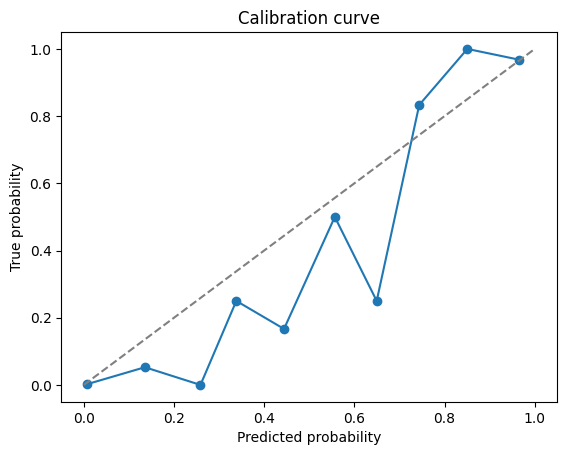

In [5]:
# Calibration (Brier score) and PR-AUC demo (recomputes small model quickly for independence)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import numpy as np, tensorflow as tf
from tensorflow import keras

# Quick binary model
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28*28)/255.0; x_test = x_test.reshape(-1,28*28)/255.0
y_train_bin = (y_train.flatten()==0).astype(int); y_test_bin = (y_test.flatten()==0).astype(int)
model = keras.Sequential([keras.layers.Dense(64,activation='relu',input_shape=(28*28,)), keras.layers.Dense(1,activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train[:2000], y_train_bin[:2000], epochs=3, verbose=0)
probs = model.predict(x_test[:1000]).flatten(); preds = (probs>=0.5).astype(int)
brier = brier_score_loss(y_test_bin[:1000], probs)
precision, recall, _ = precision_recall_curve(y_test_bin[:1000], probs)
pr_auc = auc(recall, precision)
avg_prec = average_precision_score(y_test_bin[:1000], probs)
print(f"Brier score (lower better, perfect=0): {brier:.4f}")
print(f"PR-AUC (area under PR curve): {pr_auc:.4f}, Average precision: {avg_prec:.4f}")

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test_bin[:1000], probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve')
plt.show()

## Notes, further reading and next steps

- This notebook is an *executable handbook*. Each cell includes a runnable example that shows the metric computation and interpretation.
- For real projects, expand evaluation to include distribution-shift tests, robustness (noise, occlusion), fairness metrics, and human evaluation for generative models.
- Good references: scikit-learn metrics docs, TensorFlow Model Analysis (TFMA) for production evaluation, HELM paper for LLM evaluation.

---

*Created as your practical benchmark & evaluation handbook. Run the notebook, experiment with thresholds, dataset splits, and metric combinations to build intuition.*
